In [1]:
## LOAD MODULES ##

# third party
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path
import psyplot.project as psy
import pandas as pd
import xarray
from netCDF4 import Dataset,date2num
import metpy.calc as calc
from metpy.units import units
import datetime as dt
import pandas as pd
import xarray as xr
from os.path import join, basename
import matplotlib.dates as mdates
from iconarray.plot import formatoptions # import plotting formatoptions (for use with psyplot)
import iconarray as iconvis # import self-written modules from iconarray

# first party
sys.path.append('../mapplot/')
from timefunctions import *
import varfunctions as vf
import locfunctions as lf

INFO:numexpr.utils:Note: NumExpr detected 36 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [57]:
## DECIDE ##
# where to save
plotpath_base = '/scratch/tlezuo/icon-vis/lidar/data/'
# from where to load
li_path = '/users/tlezuo/data/2D/SL88/'
filename = 'sl88_20190913_vad.nc'
filepath = li_path + filename

## LOAD DATA ##
with xr.open_dataset(filepath) as temp:
    ds = xr.Dataset({'u': (['height', 'time'], temp.ucomp.values),
                                    'v': (['height', 'time'], temp.vcomp.values),
                                    'w': (['height', 'time'], temp.wcomp.values),
                                    'VEL': (['height', 'time'], temp.ff.values)},
                                    coords={'time': temp.time.values,
                                            'height': temp.height.values +
                                            temp.alt,
                                            'datenum': ('time',
                                                        temp.datenum.values)})
# average over 10 min                                                       
ds = ds.resample(time='10min').mean()
# refine
ds = ds.assign_coords({'datenum': ('time', mdates.date2num(ds.time))})
ds = ds.assign_attrs(dict(Name="Lidar SL88")) 


In [ ]:
## SAVE RADIOSOUNDING DATA ##
ds.to_netcdf(path=plotpath_base+'lidar_data_lidar_Kolsass.nc', mode='w',format="NETCDF4")

Text(0, 0.5, 'VEL [m/s]')

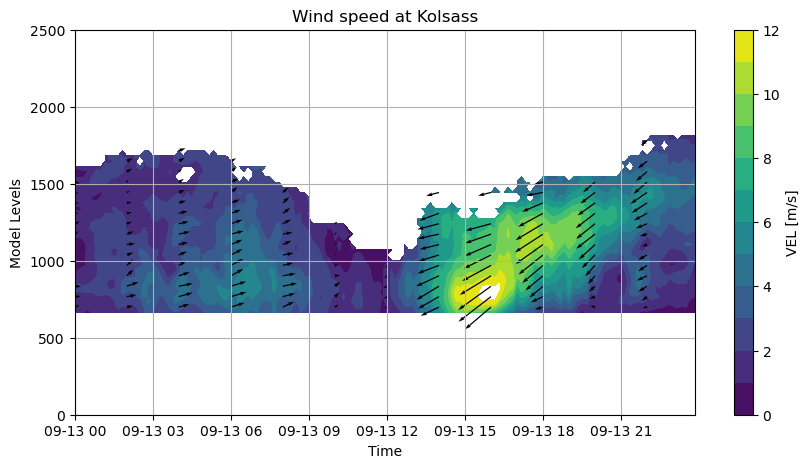

In [52]:
## TEST LIDAR PLOT ##
# select variable
pvar=vf.VEL
loc=lf.kols
# ds = ds.transpose()

# set date
x = ds.time
y = ds.height
x, y = np.meshgrid(x,y)
z = ds.VEL
u = ds.u.data
v= ds.v.data
levels = np.arange(pvar.min,pvar.max,pvar.ticks)
levels = np.arange(pvar.min,13,pvar.ticks)

#create plot
fig, ax = plt.subplots(1,1, figsize=(10,5))
plt.contourf(x,y,z, levels = levels)

cbar = plt.colorbar()
# add windbarbs
dx = 12
dy = 2
q_scale = 30
q_width = 0.002
ax.quiver(x[::dy,::dx], y[::dy,::dx], 
        u[::dy,::dx], #U
        v[::dy,::dx], #V
        scale=q_scale, scale_units='inches',
        width=q_width)

# plotting options
ax.set_ylim(0,2500) # lowest 30 levels
ax.grid()
ax.set_title(pvar.title+' at '+loc.name)
ax.set_xlabel('Time')
ax.set_ylabel('Model Levels')
cbar.ax.set_ylabel(pvar.name + ' ' + pvar.units)